In [1]:
import networkx as nx
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import shapely
import snkit
import snkit.network
import igraph as ig
import ast
from ast import literal_eval
import math 
import numpy as np
import multiprocessing as mp
import os
import pickle

crs_fr = 4326
plt.rcParams['figure.figsize'] = (10, 10)

In [2]:
# import packages
%run -i packages.py

# CUSTOM FUNCTIONS

# define function that creates attribute dictionary for nodes and edges
# (for input to nx.add_edges_from/add_nodes_from)
def make_attr_dict(*args, **kwargs): 
    
    argCount = len(kwargs)
    
    if argCount > 0:
        attributes = {}
        for kwarg in kwargs:
            attributes[kwarg] = kwargs.get(kwarg, None)
        return attributes
    else:
        return None # (if no attributes are given)
    
# computes pathlength by nx - handling error message if nodes are not connected/not part of the network
def pathlength_if_connected(my_nw, my_o, my_d):
    try:
        return(nx.dijkstra_path_length(my_nw, my_o, my_d, weight = "length"))
    except:
        return(math.inf)
    
# get list of edge coordinates for plotting from list of nx edge ids:
def get_path_coords(my_path, my_coorddict):
    pathcoords = []
    for edge_id in my_path:
        edge_coords = [(c[0], c[1]) for c in my_coorddict[tuple(edge_id)].coords]
        pathcoords.append(edge_coords)
    return(pathcoords) 

# Check function
def check_missing_nodes(set11, set12, node_IDs):
    set11 = set(set11)
    set12 = set(set12)
    node_IDs = set(node_IDs)
    IDs_in_edges = set11.union(set12)
    missing = list(sorted(IDs_in_edges - node_IDs))
    added = list(sorted(node_IDs - IDs_in_edges))
    return(missing, added)

# change edge id to list of int
def convert_path_to_list(path_string):
    path_list = ast.literal_eval(path_string)
    return path_list

In [3]:
# Get boundary of GPM (for plots)
GPM = gpd.read_file('data/raw/GPM_geometry/GPM.geojson').to_crs(crs_fr)

# Create complete network
- get all layers created so far (IRIS, centroids, roads for cars and bikes, public transport layer(s))

- connect centroids to the carbike network: 
    - combine centroids and carbike nodes into one nodes_network dataframe
    - put the combined nodes and the carbike edges into snkit
    - create a base_network with them, create a linked network
    - go back to separate carbike and centroid dataframes as needed



## Get layers

### Centroids

In [4]:
# Get grid and centroids
grid = gpd.read_file('data/raw/IRIS_GPM.geojson')

# turn into geodataframe and separate centroids 
grid['centroid'] = grid.centroid
centroids = grid.drop(columns = 'geometry').rename(columns = {'centroid':'geometry'}).set_geometry('geometry').to_crs(2154)


# Adding necessary attributes for the network
centroids['nodetype'] = 'both'
centroids['centroid'] = True
centroids['RER'] = False

# Make a new dataframe for the network just in case TODO move to the nextwork building cell 
centroids_network = centroids.to_crs(crs_fr)
centroids_network['x'] = centroids_network['geometry'].x
centroids_network['y'] = centroids_network['geometry'].y

centroids_network


,CODE_IRIS,geometry,nodetype,centroid,RER,x,y
0,920440109,POINT (2.28928 48.89521),both,True,False,2.289280,48.895206
1,930270105,POINT (2.40273 48.92223),both,True,False,2.402726,48.922227
2,751197316,POINT (2.37442 48.89225),both,True,False,2.374425,48.892245
3,751176716,POINT (2.30742 48.88866),both,True,False,2.307418,48.888659
4,920020104,POINT (2.31126 48.76564),both,True,False,2.311259,48.765645
...,...,...,...,...,...,...,...
2661,930290203,POINT (2.45812 48.92539),both,True,False,2.458119,48.925392
2662,920070111,POINT (2.31503 48.79468),both,True,False,2.315035,48.794683
2663,930050101,POINT (2.48084 48.94737),both,True,False,2.480841,48.947369
2664,920190113,POINT (2.27666 48.76719),both,True,False,2.276657,48.767193


### roads 

In [5]:
# Get roads (car/bike, nodes/edges)
edges_carbike = pd.read_csv("./data/processed/carbike_edges_bothtype.csv")
nodes_carbike = pd.read_csv("./data/processed/carbike_nodes_bothtype.csv")

In [6]:
#--- Getting the nodes ready for the network

# Add attributes
nodes_carbike['centroid'] = False
nodes_carbike['RER'] = False    

# Turn into GeoDataFrame
nodes_carbike["geometry"] = nodes_carbike.apply(lambda x: shapely.wkt.loads(x.geometry), axis = 1)
nodes_carbike = gpd.GeoDataFrame(nodes_carbike, geometry = 'geometry', crs = crs_fr)

# Re-create x and y columns
nodes_carbike['x'] = nodes_carbike['geometry'].x
nodes_carbike['y'] = nodes_carbike['geometry'].y


In [7]:
check_missing_nodes(edges_carbike['x'], edges_carbike['y'], nodes_carbike['osmid'])

([], [])

In [8]:
# Turn to GeoDataFrame
edges_carbike["geometry"] = edges_carbike.apply(lambda x: shapely.wkt.loads(x.geometry), axis = 1)
edges_carbike = gpd.GeoDataFrame(edges_carbike, geometry = "geometry", crs = crs_fr) 

In [9]:
check_missing_nodes(edges_carbike['x'], edges_carbike['y'], nodes_carbike['osmid'])

([], [])

#### Find biggest connected component and only work with that

In [10]:
#--- Checking for connectedness 

# Create Networkx Graph
G1 = nx.from_pandas_edgelist(edges_carbike, source='x', target='y', edge_attr=True, create_using=nx.DiGraph)
# G1.add_nodes_from(nodes.loc[:,["osmid", "attr_dict"]].itertuples(index = False))
G1.add_nodes_from(nodes_carbike.loc[:,"osmid"])

# Find disconnected components
S1 = [G1.subgraph(c).copy() for c in nx.weakly_connected_components(G1)] 

#--- Compute some statistics
graph_below_2_nodes = 0
graph_above_2_nodes = 0
big_graph = 0

lengthlist = []
for index in range(len(S1)):
    lengthlist.append(len(S1[index]))
    if len(S1[index]) < 3 :
        graph_below_2_nodes+=1
    elif len(S1[index]) > 100 :
        big_graph +=1
    else:
        graph_above_2_nodes+=1

lengthS1 = 0
for edge in S1[0].edges:
    lengthS1 += edges_carbike.loc[(edges_carbike['x'] == edge[0]) & (edges_carbike['y'] == edge[1]), 'length'].values[0]

# Print the statistics
print("disconnected components with 2 nodes or less ", graph_below_2_nodes)
print("disconnected components with 3 or more nodes, less than 100", graph_above_2_nodes)
print("disconnected components with 100 or more nodes", big_graph)
print("total number of disconnected components", len(S1))
print("Percentage of edges in the largest component", len(S1[0]) / len(edges_carbike) * 100) 
print("Percentage of km of edges in the largest component", lengthS1 / edges_carbike['length'].sum() * 100)

disconnected components with 2 nodes or less  592
disconnected components with 3 or more nodes, less than 100 140
disconnected components with 100 or more nodes 1
total number of disconnected components 733
Percentage of edges in the largest component 55.75114243133075
Percentage of km of edges in the largest component 72.00105177294279


In [11]:
#--- Only work with the largest connected component

# Make the largest connected component undirected
H = S1[0].to_undirected()

# Export the edges of the graph to a pandas dataframe
edges_carbike_connected = nx.to_pandas_edgelist(H, source='x', target='y')
# edges_carbike_connected["geometry"] = edges_carbike_connected.apply(lambda x: shapely.wkt.loads(x.geometry), axis = 1)
edges_carbike_connected = gpd.GeoDataFrame(edges_carbike_connected, geometry = 'geometry', crs = crs_fr)

# Filter the nodes dataframe to only include the nodes that are in the largest connected component
nodes_carbike_connected = nodes_carbike.loc[nodes_carbike['osmid'].isin(edges_carbike_connected['x']) | nodes_carbike['osmid'].isin(edges_carbike_connected['y'])]

In [12]:
# Check if the resulting network is connected 
G2 = nx.from_pandas_edgelist(edges_carbike_connected, source='x', target='y', edge_attr=True, create_using=nx.DiGraph)
# G1.add_nodes_from(nodes.loc[:,["osmid", "attr_dict"]].itertuples(index = False))
G2.add_nodes_from(nodes_carbike_connected.loc[:,"osmid"])

# Find disconnected components
S2 = [G2.subgraph(c).copy() for c in nx.weakly_connected_components(G2)] 
print(len(S2))
H = S2[0].to_undirected()
print(nx.is_connected(H))


1
True


In [13]:
# # Plot

# ax = plt.axes()
# edges_carbike_connected.plot(ax=ax, linewidth = 0.3, alpha = 0.5)
# nodes_carbike_connected.plot(ax=ax, markersize = 0.05, facecolor = 'red', alpha = 1)
# GPM.plot(ax=ax, facecolor = 'none', linewidth = 2)

### RER and Metro (not relevant anymore)

In [14]:
# #--- Get data
# RER_stations = pd.read_csv("./data/processed/RER_stations.csv")
# RER_lines = pd.read_csv("./data/processed/RER_lines.csv")

In [15]:
# check_missing_nodes(RER_lines.x, RER_lines.y, RER_stations.id) 

In [16]:
# #--- Add necessary attributes

# # For lines
# RER_lines['edgetype'] = 'RER'

# # For stations
# RER_stations['nodetype'] = 'bike'
# RER_stations['centroid'] = False
# RER_stations['RER'] = True
# RER_stations = RER_stations.rename(columns = {'id': 'osmid'})

In [17]:
# #--- turn to GeoDataFrame
# RER_stations["geometry"] = RER_stations.apply(lambda x: shapely.wkt.loads(x.geometry), axis = 1)
# RER_stations = gpd.GeoDataFrame(RER_stations, geometry = 'geometry', crs = 2154).to_crs(crs_fr)
# RER_lines["geometry"] = RER_lines.apply(lambda x: shapely.wkt.loads(x.geometry), axis = 1)
# RER_lines = gpd.GeoDataFrame(RER_lines, geometry = 'geometry', crs = 2154).to_crs(crs_fr)


## Connect carbike edges, centroids and RER stations
A network is created with
- nodes = centroids, RER stops and road intersections
- edges = roads

These edges and nodes will be connected by creating an edge between each centroid/RER station and its nearest carbike edge. The intersection between the new edge and the old edge will become a new node, and the old edge will be split into two new edges. 

In [18]:
#--- Create dataframe with all carbike nodes and centroids 

# with
nodes_network = pd.concat([centroids_network, nodes_carbike_connected])#RER_stations (put first if using the RER stuff too)

In [19]:
nodes_network[nodes_network['centroid'] == True]

# If 2066, we're good to go

,CODE_IRIS,geometry,nodetype,centroid,RER,x,y,osmid
0,920440109,POINT (2.28928 48.89521),both,True,False,2.289280,48.895206,NaN
1,930270105,POINT (2.40273 48.92223),both,True,False,2.402726,48.922227,NaN
2,751197316,POINT (2.37442 48.89225),both,True,False,2.374425,48.892245,NaN
3,751176716,POINT (2.30742 48.88866),both,True,False,2.307418,48.888659,NaN
4,920020104,POINT (2.31126 48.76564),both,True,False,2.311259,48.765645,NaN
...,...,...,...,...,...,...,...,...
2661,930290203,POINT (2.45812 48.92539),both,True,False,2.458119,48.925392,NaN
2662,920070111,POINT (2.31503 48.79468),both,True,False,2.315035,48.794683,NaN
2663,930050101,POINT (2.48084 48.94737),both,True,False,2.480841,48.947369,NaN
2664,920190113,POINT (2.27666 48.76719),both,True,False,2.276657,48.767193,NaN


In [20]:
#--- Creating the network 

# Nodes 
nodes = gpd.GeoDataFrame(nodes_network, geometry = "geometry", crs = crs_fr)

# Edges
edges = edges_carbike_connected

# Network
base_network = snkit.Network(nodes, edges)

# # Plot
# ax = plt.axes()
# base_network.edges.plot(ax=ax, linewidth = 1, alpha = 0.6)
# base_network.nodes.plot(ax=ax, facecolor = 'red', markersize = 3)

In [21]:
nodes.head(1)

,CODE_IRIS,geometry,nodetype,centroid,RER,x,y,osmid
0,920440109,POINT (2.28928 48.89521),both,True,False,2.28928,48.895206,NaN


In [22]:
edges.head(1)

,x,y,length,edgetype,geometry,edge_id
0,122926,318399738,1618.6,car,"LINESTRING (2.46355 48.88408, 2.46236 48.88415...","[122926, 318399738]"


In [23]:
#--- CHECK - still connected?

# Create Graph with all nodes and edges from base_network
G = nx.from_pandas_edgelist(base_network.edges, source='x', target='y', edge_attr=True)

# Need to filter for carbike nodes since RER and centroids are obviously not connected 
G.add_nodes_from(base_network.nodes.loc[(base_network.nodes['centroid'] == False) & (base_network.nodes['RER'] == False)]['osmid'])


#--- Make both networks undirected
G = G.to_undirected()
print(nx.is_connected(G))


True


In [24]:
# Quick check of consistency
len(check_missing_nodes(base_network.edges['x'], base_network.edges['y'], base_network.nodes['osmid'])[1]) #2991 is good!

2666

In [25]:
%%time 
#--- Link centroids to their nearest edge (takes about 16min)

linked = snkit.network.link_nodes_to_nearest_edge(base_network) #wth is this warning?
# # plot
# ax = plt.axes()
# linked.edges.plot(ax=ax, linewidth = 1, alpha = 0.5)
# linked.nodes.plot(ax=ax, facecolor = 'red', markersize = 3, alpha = 1)

/Users/auriane/opt/miniconda3/envs/thesis/lib/python3.10/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(
/Users/auriane/opt/miniconda3/envs/thesis/lib/python3.10/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(


CPU times: user 13min 41s, sys: 5.15 s, total: 13min 46s
Wall time: 13min 49s


In [26]:
# create IDs for the new nodes and edges 
with_id = snkit.network.add_topology(snkit.network.add_ids(linked))

In [27]:
#--- CHECK - still connected?

# Create Graph with all nodes and edges from with_id
G = nx.from_pandas_edgelist(with_id.edges, source='from_id', target='to_id', edge_attr=True)
G.add_nodes_from(with_id.nodes['id'])


#--- Make both networks undirected
G = G.to_undirected()
print(nx.is_connected(G))


True


In [28]:
with_id.edges.isnull().sum()
# The edges without and x and y attribute are the ones that were created by the link_nodes_to_nearest_edge function

x           2666
y           2666
length      2666
edgetype    2666
geometry       0
edge_id     2666
id             0
from_id        0
to_id          0
dtype: int64

In [29]:
with_id.nodes.isnull().sum() 
# The nodes that don't have a centroid/nodetype/RER attribute are the newly created nodes (splitting and old edge) = 2851
# The nodes that don't have an osmid are the new nodes + centroids  = 5695

CODE_IRIS    115512
geometry          0
nodetype       2539
centroid       2539
RER            2539
x              2539
y              2539
osmid          5205
id                0
dtype: int64

In [30]:
# Separate old nodes (centroids and carbike nodes) from new ones (intersection between centroid and nearest edge) 
new_carbike_nodes = with_id.nodes[with_id.nodes['nodetype'].isnull()]

# Separate centroids from the other nodes of this network 
centroids_network = with_id.nodes[with_id.nodes['centroid'] == True]

# Separate RER stations from the other nodes of this network 
RER_stations_network = with_id.nodes[with_id.nodes['RER'] == True]

In [31]:
with_id.nodes.head(10)
# CHECK Make sure the first nodes are from the RER network AND their osmid and id overlap!!

,CODE_IRIS,geometry,nodetype,centroid,RER,x,y,osmid,id
0,920440109,POINT (2.28928 48.89521),both,True,False,2.289280,48.895206,NaN,node_0
1,930270105,POINT (2.40273 48.92223),both,True,False,2.402726,48.922227,NaN,node_1
2,751197316,POINT (2.37442 48.89225),both,True,False,2.374425,48.892245,NaN,node_2
3,751176716,POINT (2.30742 48.88866),both,True,False,2.307418,48.888659,NaN,node_3
4,920020104,POINT (2.31126 48.76564),both,True,False,2.311259,48.765645,NaN,node_4
5,940210107,POINT (2.35755 48.77377),both,True,False,2.357553,48.773767,NaN,node_5
6,950180701,POINT (2.22533 48.96541),both,True,False,2.225332,48.965406,NaN,node_6
7,751103703,POINT (2.35696 48.87811),both,True,False,2.356962,48.878110,NaN,node_7
8,930050802,POINT (2.50821 48.94917),both,True,False,2.508207,48.949173,NaN,node_8
9,930500112,POINT (2.52771 48.86905),both,True,False,2.527707,48.869051,NaN,node_9


## Post-linking processing
The current network is connected, but still missing some things.
- snkit has attributed IDs to all nodes, even though most ndoes already have a native ID. This needs fixing
- snkit has created new nodes and edges, some work needs to be done there to ensure everything is in order
- the edges now use the snkit IDs instead of the original ones. This needs fixing
- the RER lines have not been included yet
- Once all nodes have been made compatible with the old data, they need to be processed for NetworkX. 

### Nodes
- Make centroids and RER stations compatible with carbike nodes
- Make the new nodes compatible with the carbike nodes
- Add the new nodes to the carbike nodes
- Process all carbike nodes (old and new)

In [32]:
#--- Process centroids 
centroids_network = centroids_network.drop(columns = 'osmid')
centroids_network = centroids_network.rename(columns = {'id':'osmid'})
centroids_network['osmid'] = centroids_network['osmid'].str[5:].astype(int)

centroids_network.head(3)

,CODE_IRIS,geometry,nodetype,centroid,RER,x,y,osmid
0,920440109,POINT (2.28928 48.89521),both,True,False,2.289280,48.895206,0
1,930270105,POINT (2.40273 48.92223),both,True,False,2.402726,48.922227,1
2,751197316,POINT (2.37442 48.89225),both,True,False,2.374425,48.892245,2


In [33]:
#--- Process new carbike nodes 
new_carbike_nodes = new_carbike_nodes.drop(columns = 'osmid')
new_carbike_nodes = new_carbike_nodes.rename(columns = {'id':'osmid'})

# Add attributes 
new_carbike_nodes['nodetype'] = 'both'
new_carbike_nodes['osmid'] = new_carbike_nodes['osmid'].str[5:].astype(int)
new_carbike_nodes['centroid'] = False
new_carbike_nodes['RER'] = False

new_carbike_nodes.tail(1)

,CODE_IRIS,geometry,nodetype,centroid,RER,x,y,osmid
118177,NaN,POINT (2.39423 48.91159),both,False,False,NaN,NaN,118177


In [34]:
# #--- Process RER nodes 
# RER_stations_network['osmid'] = RER_stations_network['osmid'].astype(int)
# RER_stations_network = RER_stations_network.drop(columns = 'id')
# RER_stations_network.head(1)

In [35]:
#-- Process old carbike nodes
nodes_carbike_connected.head(1)

,osmid,y,x,geometry,nodetype,centroid,RER
0,122926,48.884082,2.463549,POINT (2.46355 48.88408),car,False,False


In [36]:
# QUICK CHECK: ARE ALL IDs REALLY DIFFERENT FROM EACH OTHER? 
# RER_stations_network_minID = int(RER_stations_network.sort_values(by = 'osmid').head(1).osmid)
# RER_stations_network_maxID = int(RER_stations_network.sort_values(by = 'osmid').tail(1).osmid)
centroids_minID = int(centroids_network.sort_values(by = 'osmid').head(1).osmid)
centroids_maxID = int(centroids_network.sort_values(by = 'osmid').tail(1).osmid)
new_carbike_nodes_minID = int(new_carbike_nodes.sort_values(by = 'osmid').head(1).osmid)
new_carbike_nodes_maxID = int(new_carbike_nodes.sort_values(by = 'osmid').tail(1).osmid)
nodes_all_minID = int(nodes_carbike_connected.sort_values(by = 'osmid').head(1).osmid)
nodes_all_maxID = int(nodes_carbike_connected.sort_values(by = 'osmid').tail(1).osmid)

print(#'\nRER min ', RER_stations_network_minID, 
      #'\nRER min ', RER_stations_network_maxID, 
      '\ncentroid min ', centroids_minID, 
      '\ncentroid max ', centroids_maxID, 
      '\nnew carbike min ', new_carbike_nodes_minID, 
      '\nnew carbike max ', new_carbike_nodes_maxID,
      '\nold carbike min ', nodes_all_minID, 
      '\nold carbike max ',nodes_all_maxID) 


centroid min  0 
centroid max  2665 
new carbike min  115639 
new carbike max  118177 
old carbike min  122926 
old carbike max  11006222342


In [37]:
#--- Combine all nodes 
nodes_carbike_centroids_RER_complete = pd.concat([nodes_carbike_connected, new_carbike_nodes, centroids_network])#, RER_stations_network]) 
nodes_carbike_centroids_RER_complete = gpd.GeoDataFrame(nodes_carbike_centroids_RER_complete, geometry = "geometry", crs=crs_fr)

# Replace or fill in x and y attributes
nodes_carbike_centroids_RER_complete = nodes_carbike_centroids_RER_complete.to_crs(crs_fr)
nodes_carbike_centroids_RER_complete['x'] = nodes_carbike_centroids_RER_complete.geometry.apply(lambda p: p.x)
nodes_carbike_centroids_RER_complete['y'] = nodes_carbike_centroids_RER_complete.geometry.apply(lambda p: p.y)

#--- Dealing with the nodes like we used to (Anastassia) 
# Sort values and drop duplicates 
nodes_carbike_centroids_RER_complete = nodes_carbike_centroids_RER_complete.sort_values(by = "osmid").reset_index(drop = True) # sort by osmid
# make attribute dictionary with type and geocoordinates for each node
# MOD: removed category_node = x.type 
# MOD: changed coord to geometry
# MOD-Stpehan : split geometry into lat and lon
# MOD: added centroid and RER as attributes 
nodes_carbike_centroids_RER_complete["attr_dict"] = nodes_carbike_centroids_RER_complete.apply(lambda x: make_attr_dict(lat = x.x,
                                                                  lon = x.y,
                                                                  pos = (x.x, x.y),
                                                                  nodetype = x.nodetype,
                                                                  centroid = x.centroid,
                                                                  RER = x.RER),
                                                                  axis = 1) 

nodes_carbike_centroids_RER_complete["osmid"] = nodes_carbike_centroids_RER_complete["osmid"].astype(int)
nodes_carbike_centroids_RER_complete.head(1) #make sure the top nodes are RER!

/var/folders/2m/lkz691q11b72bpprh6_v34_h0000gn/T/ipykernel_18233/1110685033.py:2: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  nodes_carbike_centroids_RER_complete = pd.concat([nodes_carbike_connected, new_carbike_nodes, centroids_network])#, RER_stations_network])


,osmid,y,x,geometry,nodetype,centroid,RER,CODE_IRIS,attr_dict
0,0,48.895206,2.28928,POINT (2.28928 48.89521),both,True,False,920440109,"{'lat': 2.289279563873589, 'lon': 48.895205539..."


In [38]:
nodes_carbike_centroids_RER_complete.dtypes

osmid           int64
y             float64
x             float64
geometry     geometry
nodetype       object
centroid       object
RER            object
CODE_IRIS      object
attr_dict      object
dtype: object

In [39]:
# QUICK CHECKS 
# This should be 118704, or the max id of the centroids/new carbike nodes/RER nodes together 
print('max id of nodes that are NOT in the edges dataframe ',
      max(check_missing_nodes(linked.edges['x'], linked.edges['y'], nodes_carbike_centroids_RER_complete['osmid'])[1])) 
# This should be 5840, same reasoning as above
print('number of nodes that are NOT in the edges dataframe ',
      len(check_missing_nodes(linked.edges['x'], linked.edges['y'], nodes_carbike_centroids_RER_complete['osmid'])[1])) 

# This should be nan
print('number of edges with nodes that are NOT in the nodes dataframe ', 
      min(check_missing_nodes(linked.edges['x'], linked.edges['y'], nodes_carbike_centroids_RER_complete['osmid'])[0])) 



max id of nodes that are NOT in the edges dataframe  118177
number of nodes that are NOT in the edges dataframe  5205
number of edges with nodes that are NOT in the nodes dataframe  nan


### Edges
- Make new edges compatible with the old ones
    - some new edges connect with a node from the carbike network using the ID given by linked_network instead of the original osmID -> change these IDs into their osmIDs AND update this info in the edges df
    - These IDs are already absent from the nodes_carbike_complete df since it is based on the old nodes_all df and the new_nodes and centroids dfs
- Add RER edges

In [40]:
#--- Make with_id.nodes and edges workable

n = 5
edges_with_id = with_id.edges
edges_with_id['from_id'] = edges_with_id['from_id'].str[5:].astype(int)
edges_with_id['to_id'] = edges_with_id['to_id'].str[5:].astype(int)
edges_with_id['id'] = edges_with_id['id'].str[5:].astype(int)

print(max(check_missing_nodes(edges_with_id['from_id'], edges_with_id['to_id'], nodes_carbike_connected['osmid'])[0]) )
# highest missing id in edges should be BELOW all of those in the nodes dataframe (i.e below 122926) 

print(min(check_missing_nodes(edges_with_id['from_id'], edges_with_id['to_id'], nodes_carbike_connected['osmid'])[1]) )
# lowest missing ID in nodes should be the lowest original osmid (i.e 122926), need to overwrite the nodes id in edges with their new value

118177
122926


In [41]:
#--- Replacing new IDs with osmIDs where necessary

# Create a dictionary of ID to osmID
oldnodes_in_newedges = with_id.nodes.loc[(with_id.nodes['osmid'].notnull())] # They have an non-null osmID (the new nodes don't have one)
oldnodes_in_newedges['osmid'] = oldnodes_in_newedges['osmid'].astype(int)
oldnodes_in_newedges['id'] = oldnodes_in_newedges['id'].str[5:].astype(int)
oldnodes_in_newedges.set_index('id',inplace=True)
id_osmid_dict = oldnodes_in_newedges.to_dict()['osmid']

# Replace IDs with osmIDs in the edges dataframe
edges_with_id['from_id'] = edges_with_id['from_id'].apply(lambda row: id_osmid_dict[row] if row in (id_osmid_dict.keys()) else row)
edges_with_id['to_id'] = edges_with_id['to_id'].apply(lambda row: id_osmid_dict[row] if row in (id_osmid_dict.keys()) else row)

edges_with_id.isnull().sum()

/Users/auriane/opt/miniconda3/envs/thesis/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


x           2666
y           2666
length      2666
edgetype    2666
geometry       0
edge_id     2666
id             0
from_id        0
to_id          0
dtype: int64

In [42]:
#--- CHECK - still connected?

# Create Graph with all nodes and edges from with_id
G = nx.from_pandas_edgelist(edges_with_id, source='from_id', target='to_id', edge_attr=True)
G.add_nodes_from(nodes_carbike_centroids_RER_complete['osmid'])


#--- Make both networks undirected
G = G.to_undirected()
print(nx.is_connected(G))


True


In [43]:
#--- CHECK Routing between centroids
# Pick two random nodes with centroid = True
start_node = nodes_carbike_centroids_RER_complete.loc[nodes_carbike_centroids_RER_complete['centroid'] == True].sample(1)
end_node = nodes_carbike_centroids_RER_complete.loc[nodes_carbike_centroids_RER_complete['centroid'] == True].sample(1)

# Check if they are connected on the car network
# TODO this should always return True!!!!!!!
print(nx.has_path(G, start_node['osmid'].iloc[0], end_node['osmid'].iloc[0]))


True


In [44]:
#--- Fill in the edgetype for the new edges 
# Create a dictionary of nodeID to nodetype
nodes_type_df = nodes_carbike_centroids_RER_complete
nodes_type_dict = nodes_type_df.reset_index(drop = True)
nodes_type_dict = nodes_type_dict.set_index('osmid').to_dict()['nodetype']


# Find the correct column indexes to work with
index_edgetype = edges_with_id.columns.get_loc("edgetype")
index_fromID = edges_with_id.columns.get_loc("from_id")
index_toID = edges_with_id.columns.get_loc("to_id")
index_x = edges_with_id.columns.get_loc("x")
index_y = edges_with_id.columns.get_loc("y")
index_edge_id = edges_with_id.columns.get_loc("edge_id")

# Fill in the edgetype 
# With the nodetype of the from_id and to_id if it is the same
# With 'car' if it is different
for i in range(len(edges_with_id)):
    if pd.isnull(edges_with_id.iloc[i,index_edgetype]):
        if nodes_type_dict[edges_with_id.iloc[i,index_fromID]] == nodes_type_dict[edges_with_id.iloc[i,index_toID]]:
            edges_with_id.iloc[i,index_edgetype] = nodes_type_dict[edges_with_id.iloc[i,index_toID]]
        else:
            edges_with_id.iloc[i,index_edgetype] = 'car'
edges_with_id.isnull().sum() # no more NaN on edgetype?

x           2666
y           2666
length      2666
edgetype       0
geometry       0
edge_id     2666
id             0
from_id        0
to_id          0
dtype: int64

In [45]:
#--- Fill in the x and y columns 
# With x = from_id and y = to_id
for i in range(len(edges_with_id)):
    edges_with_id.iloc[i,index_x] = edges_with_id.iloc[i,index_fromID]
    edges_with_id.iloc[i,index_y] = edges_with_id.iloc[i,index_toID]
# edges_with_id['x'] = edges_with_id['x'].astype(int)
# edges_with_id['y'] = edges_with_id['y'].astype(int)


#--- Fill in the edge_id column where it is NaN with [from_id, to_id]
edges_with_id['edge_id'] = edges_with_id.apply(lambda row: str([row["x"], row["y"]]), axis = 1)
# Convert edges_with_id.edge_id from string to list of int
edges_with_id['edge_id'] = edges_with_id['edge_id'].apply(lambda cell:
                                      ''.join(c for c in cell if c not in "'[]").split(', '))

#--- Drop unnecessary columns
# edges_with_id = edges_with_id.drop(['from_id','to_id', 'id'], axis = 1)

edges_with_id.isnull().sum() # no more NaN on x, y and edge_id?

x              0
y              0
length      2666
edgetype       0
geometry       0
edge_id        0
id             0
from_id        0
to_id          0
dtype: int64

In [46]:
#--- CHECK - still connected?

# Create Graph with all nodes and edges from with_id
G = nx.from_pandas_edgelist(edges_with_id, source='x', target='y', edge_attr=True)
G.add_nodes_from(nodes_carbike_centroids_RER_complete['osmid'])


#--- Make both networks undirected
G = G.to_undirected()
print(nx.is_connected(G))

True


In [47]:
#--- CHECK Routing between centroids
# Pick two random nodes with centroid = True
start_node = nodes_carbike_centroids_RER_complete.loc[nodes_carbike_centroids_RER_complete['centroid'] == True].sample(1)
end_node = nodes_carbike_centroids_RER_complete.loc[nodes_carbike_centroids_RER_complete['centroid'] == True].sample(1)

# Check if they are connected on the car network
# TODO this should always return True!!!!!!!
print(nx.has_path(G, start_node['osmid'].iloc[0], end_node['osmid'].iloc[0]))


True


In [48]:
# #--- Adding the RER line

# # Append RER edges 
# edges_with_id = edges_with_id.append(RER_lines.drop(columns = 'reseau'), ignore_index = True)

# # Are all RER stations connected to RER lines?
# # Are all RER lines starting at ending at RER nodes?
# print(check_missing_nodes(edges_with_id.loc[edges_with_id['edgetype'] == 'RER']['x'], 
#                     edges_with_id.loc[edges_with_id['edgetype'] == 'RER']['y'], 
#                     nodes_carbike_centroids_RER_complete.loc[nodes_carbike_centroids_RER_complete['RER']==True]['osmid'])
# )
# # TODO add an edge ID to RER lines! 
# # Are all RER lines present?
# print('forgotten lines = ', len(RER_lines) - len(edges_with_id.loc[edges_with_id['edgetype'] == 'RER']))
# # Are all RER stations present?
# print('forgotten stations = ', len(RER_stations) - len(nodes_carbike_centroids_RER_complete.loc[nodes_carbike_centroids_RER_complete['RER']==True]))


In [49]:
#--- Fill in the 'length' column
edges_with_id = edges_with_id.set_crs(crs_fr).to_crs(2154) #change crs for accuracy of length
edges_with_id['length'] = edges_with_id.length
edges_with_id = edges_with_id.to_crs(crs_fr) #change crs back to original 

#--- Drop duplicates
edges_with_id = edges_with_id.drop_duplicates(subset = ["x", "y"], keep = "first", ignore_index = True)

edges_with_id.isnull().sum() # no more NaNs at all!!

x           0
y           0
length      0
edgetype    0
geometry    0
edge_id     0
id          0
from_id     0
to_id       0
dtype: int64

In [50]:
# Add travel time column
# TODO check speeds again
# Define speeds in meters per minute #TODO add source
speed_dict = {'bike' : 250,
              'both' : 250, # If you can bike then you will bike
              'car' : 83.3,
              'RER' : 1000}

edges_with_id['weight'] = edges_with_id.apply(lambda row: row['length'] / speed_dict[row['edgetype']], axis = 1)
edges_with_id.head(1)

,x,y,length,edgetype,geometry,edge_id,id,from_id,to_id,weight
0,122926.0,318399738.0,1622.179102,car,"LINESTRING (2.46355 48.88408, 2.46236 48.88415...","[122926.0, 318399738.0]",0,122926,318399738,19.473939


In [51]:
edges_with_id.loc[edges_with_id['edgetype'] == 'both']

,x,y,length,edgetype,geometry,edge_id,id,from_id,to_id,weight
907,19405751.0,1.835516e+09,130.999279,both,"LINESTRING (2.35128 48.88374, 2.35117 48.88371...","[19405751.0, 1835516159.0]",907,19405751,1835516159,0.523997
944,979091346.0,3.999929e+09,146.312480,both,"LINESTRING (2.32776 48.88371, 2.32781 48.88367...","[979091346.0, 3999929419.0]",944,979091346,3999929419,0.585250
1332,21292407.0,2.129241e+07,252.831713,both,"LINESTRING (2.34499 48.83496, 2.34484 48.83490...","[21292407.0, 21292409.0]",1332,21292407,21292409,1.011327
1653,174996906.0,2.462866e+08,270.965866,both,"LINESTRING (2.36805 48.87951, 2.36816 48.87953...","[174996906.0, 246286550.0]",1653,174996906,246286550,1.083863
1656,621240917.0,1.780918e+07,200.200301,both,"LINESTRING (2.36719 48.87893, 2.36719 48.87887...","[621240917.0, 17809179.0]",1656,621240917,17809179,0.800801
...,...,...,...,...,...,...,...,...,...,...
169209,2661.0,1.181730e+05,9.927768,both,"LINESTRING (2.45812 48.92539, 2.45819 48.92531)","[2661.0, 118173.0]",169216,2661,118173,0.039711
169210,2662.0,1.181740e+05,0.564079,both,"LINESTRING (2.31503 48.79468, 2.31504 48.79469)","[2662.0, 118174.0]",169217,2662,118174,0.002256
169211,2663.0,1.181750e+05,58.928485,both,"LINESTRING (2.48084 48.94737, 2.48044 48.94691)","[2663.0, 118175.0]",169218,2663,118175,0.235714
169212,2664.0,1.181760e+05,17.953586,both,"LINESTRING (2.27666 48.76719, 2.27667 48.76703)","[2664.0, 118176.0]",169219,2664,118176,0.071814


In [52]:
print(check_missing_nodes(edges_with_id['x'], edges_with_id['y'], nodes_carbike_centroids_RER_complete['osmid']))
# First list empty:all nodes in nodes_carbike_complete are present in some edge of edges_with_id
# Second list empty:  all nodes in edges_with_id exist in nodes_carbike_complete

([], [])


In [53]:
#--- Save everything for future use
edges_with_id_csv = pd.DataFrame(edges_with_id)
edges_with_id_csv.to_csv('data/clean/initial_network_edges.csv', index = False)

nodes_carbike_centroids_RER_complete_csv = pd.DataFrame(nodes_carbike_centroids_RER_complete)
nodes_carbike_centroids_RER_complete_csv.to_csv('data/processed/initial_network_nodes.csv', index = False)

## Bringing it all together in NetworkX
- import all nodes and edges to one big graph
- create subgraphs for (the RER OLD) and the bike network

In [4]:
#--- Get data, turn to GeoDataFrame
# Edges
edges_with_id = pd.read_csv('data/clean/initial_network_edges.csv') 
edges_with_id['edge_id'] = edges_with_id['edge_id'].apply(convert_path_to_list)
edges_with_id['edge_id'] = edges_with_id['edge_id'].apply(lambda x: [int(float(num)) for num in x])
edges_with_id['edge_id'] = edges_with_id['edge_id'].apply(lambda x: sorted(x))
edges_with_id['x'] = edges_with_id['edge_id'].apply(lambda x: x[0])
edges_with_id['y'] = edges_with_id['edge_id'].apply(lambda x: x[1])

edges_with_id["geometry"] = edges_with_id.apply(lambda x: shapely.wkt.loads(x.geometry), axis = 1)
edges_with_id = gpd.GeoDataFrame(edges_with_id, geometry = 'geometry', crs = crs_fr)

# Nodes
nodes_carbike_centroids_RER_complete = pd.read_csv('data/clean/initial_network_nodes.csv') #TODO replace with processed/initial_network_nodes!!
nodes_carbike_centroids_RER_complete["geometry"] = nodes_carbike_centroids_RER_complete.apply(lambda x: shapely.wkt.loads(x.geometry), axis = 1)
nodes_carbike_centroids_RER_complete = gpd.GeoDataFrame(nodes_carbike_centroids_RER_complete, geometry = 'geometry', crs = crs_fr)

# GPM
GPM = GPM.to_crs(edges_with_id.crs)

In [5]:
# Recreate the attr_dict because python ...
nodes_carbike_centroids_RER_complete["attr_dict"] = nodes_carbike_centroids_RER_complete.apply(lambda x: make_attr_dict(lat = x.x,
                                                                  lon = x.y,
                                                                  pos = (x.x, x.y),
                                                                  nodetype = x.nodetype,
                                                                  centroid = x.centroid,
                                                                  RER = x.RER),
                                                                  axis = 1) 

In [6]:
#--- Create Graph with all nodes and edges
G = nx.from_pandas_edgelist(edges_with_id, source='x', target='y', edge_attr=True)
G.add_nodes_from(nodes_carbike_centroids_RER_complete.loc[:,["osmid", "attr_dict"]].itertuples(index = False))

#--- Check if all nodes and edges are present
# Both should be 0
print(len(G.nodes()) - len(nodes_carbike_centroids_RER_complete))
print(len(G.edges()) - len(edges_with_id)) #19?


0
-20


In [7]:
#--- Create "bikeable" network B (Anastassia)
B = G.copy()
bikeable_nodes = [node for node in B.nodes if B.nodes[node]["nodetype"]!="car" and B.nodes[node]["nodetype"]!="RER"] 
B_noncar_induced = B.subgraph(bikeable_nodes).copy() 

# induced subgraph - still contains the car edges that lie between multi nodes; - exclude them:
banw = B_noncar_induced.copy()
banw.remove_edges_from([edge for edge in banw.edges if banw.edges[edge]["edgetype"]=="car"])
banw.remove_edges_from([edge for edge in banw.edges if banw.edges[edge]["edgetype"]=="RER"])

#--- Check if all nodes and edges are present
# Both should be 0
print(len(banw.nodes()) 
      - len(nodes_carbike_centroids_RER_complete.loc[nodes_carbike_centroids_RER_complete['nodetype'] == 'bike']))
print(len(banw.edges()) 
      - len(edges_with_id.loc[edges_with_id['edgetype'] == 'bike']) 
      - len(edges_with_id.loc[edges_with_id['edgetype'] == 'both'])) # -3?


14527
-4


In [ ]:
# #--- Create "RER" network R (based on Anastassia)
# R = G.copy()
# RER_nodes = [node for node in R.nodes if (R.nodes[node]["RER"] == True)] 
# R_noncar_induced = R.subgraph(RER_nodes).copy() 

# # induced subgraph - still contains the car edges that lie between multi nodes; - exclude them:
# RERG = R_noncar_induced.copy()
# RERG.remove_edges_from([edge for edge in RERG.edges if RERG.edges[edge]["edgetype"]=="car"])
# RERG.remove_edges_from([edge for edge in RERG.edges if RERG.edges[edge]["edgetype"]=="bike"])

# #--- Check if all nodes and edges are present
# # Both should be 0
# print(len(RERG.nodes()) 
#       - len(nodes_carbike_centroids_RER_complete.loc[nodes_carbike_centroids_RER_complete['RER'] == True]))
# print(len(RERG.edges()) 
#       - len(edges_with_id.loc[edges_with_id['edgetype'] == 'RER']) ) 


In [8]:
#--- Make all networks undirected
G = G.to_undirected()
print(nx.is_connected(G)) # True
banw = banw.to_undirected()
print(nx.is_connected(banw)) # most likely False
# RERG = RERG.to_undirected()
# print(nx.is_connected(RERG)) # True

True
False


In [10]:
# #--- Routing between centroids
# # Pick two random nodes with centroid = True
# start_node = nodes_carbike_centroids_RER_complete.loc[nodes_carbike_centroids_RER_complete['centroid'] == True].sample(1)
# end_node = nodes_carbike_centroids_RER_complete.loc[nodes_carbike_centroids_RER_complete['centroid'] == True].sample(1)

# # Check if they are connected on the bike network
# print(nx.has_path(banw, start_node['osmid'].iloc[0], end_node['osmid'].iloc[0]))

# # Check if they are connected on the car network
# # This should always return True!!!!!!!
# print(nx.has_path(G, start_node['osmid'].iloc[0], end_node['osmid'].iloc[0]))

# #--- Routing between RER stations

# # Pick two random nodes with RER = True
# start_node = nodes_carbike_centroids_RER_complete.loc[nodes_carbike_centroids_RER_complete['RER'] == True].sample(1)
# end_node = nodes_carbike_centroids_RER_complete.loc[nodes_carbike_centroids_RER_complete['RER'] == True].sample(1)

# # Check if they are connected on the bike network
# print(nx.has_path(banw, start_node['osmid'].iloc[0], end_node['osmid'].iloc[0])) #Can be false

# # Check if they are connected on the car network
# print(nx.has_path(G, start_node['osmid'].iloc[0], end_node['osmid'].iloc[0])) #always True

# # Check if they are connected on the RER network
# print(nx.has_path(RERG, start_node['osmid'].iloc[0], end_node['osmid'].iloc[0])) #always True



False
True


<Axes: >

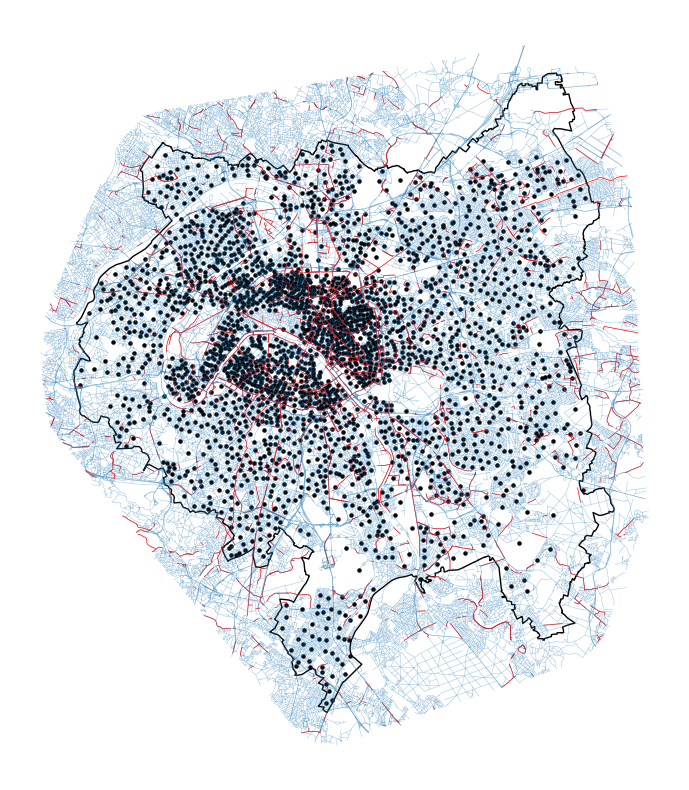

In [11]:
# # Plot of bike network Vs. car network

# ax = plt.axes()
# plt.axis('off')
# edges_with_id.loc[edges_with_id['edgetype'] == 'bike'].plot(ax=ax, linewidth = 0.5, alpha = 1, edgecolor = 'red')
# edges_with_id.loc[edges_with_id['edgetype'] == 'car'].plot(ax=ax, linewidth = 0.3, alpha = 0.5)
# nodes_carbike_centroids_RER_complete.loc[nodes_carbike_centroids_RER_complete['centroid'] == True].plot(ax=ax, markersize = 5, facecolor = 'black', alpha = 1)
# GPM.plot(ax=ax, facecolor = 'none', edgecolor = 'black', linewidth = 1)

# Set up IGraph / NetworkX interface

In [9]:
#--- Moving to igraph

# conversion to igraph
g = ig.Graph.from_networkx(G)
b = ig.Graph.from_networkx(banw)

# eids: "conversion table" for edge ids from igraph to nx 
# MOD removed literal_eval
eids_nx = [tuple(sorted(g.es(i)["edge_id"][0])) for i in range(len(g.es))]
eids_ig = [i for i in range(len(g.es))]
eids_conv = pd.DataFrame({"nx": eids_nx, "ig": eids_ig})

# nids: "conversion table" for node ids from igraph to nx
nids_nx = [g.vs(i)["_nx_name"][0] for i in range(len(g.vs))]
nids_ig = [i for i in range(len(g.vs))]
nids_conv = pd.DataFrame({"nx": nids_nx, "ig": nids_ig})

# eids_conv.to_pickle("./data/pickle/eids_conv.pickle")
# nids_conv.to_pickle("./data/pickle/nids_conv.pickle")

In [10]:
# %%time
# ### CAREFUL: THIS TAKES 1.5 HOURS!!!
# # extract edge and node attributes as dictionaries

# tnd = nx.get_node_attributes(G, "nodetype") # type of nodes dictionary tnd
# ted = nx.get_edge_attributes(G, "edgetype") # type of edges dictionary tnd
# led = nx.get_edge_attributes(G, "length") # length of edges dictionary led
# cnd = nx.get_node_attributes(G, "pos") # coordinates of nodes dictionary cnd
ced = nx.get_edge_attributes(G, "geometry") # coordinates of edges dictionary ced
ced = {tuple(sorted(key)): value for key, value in ced.items()}

# # make data frame of ebc with:
# ebc = pd.DataFrame({"edge_ig": [e.index for e in g.es]}) # igraph edge ID
# ebc["edge_nx"] = ebc.apply(lambda x: tuple(literal_eval(g.es[x.edge_ig]["edge_id"])), axis = 1) # nx edge ID
# ebc["length"] = ebc.apply(lambda x: g.es[x.edge_ig]["length"], axis = 1) # length in meters

# # compute ebcs:
# ebc["ebc_inf"] = g.edge_betweenness(directed = False, cutoff = None, weights = "length") # "standard" ebc
# # ebc["ebc_lambda"] = g.edge_betweenness(directed = False, cutoff = 2500, weights = "length") # ebc only including *paths* below 2500m



In [68]:
# ebc.to_pickle("./data/pickle/ebc.pickle")

# Identify gaps (easier to do it here than to create yet another notebook)

## Find gaps 

In [13]:
### CAREFUL: this takes over 1  hour!
# cs: set of car edges
cs = set()
for edge in eids_conv["ig"]:
    if g.es[edge]["edgetype"] == "car":
        cs.add(edge)

mygaps = []

# ALL CONTACT NODES FROM THE NETWORK
nodestack = [node.index for node in g.vs() if g.vs[node.index]["nodetype"] == "both"]
# nodestack = nodestack[:10]
count = 0

mygaps = []  # Initialize the list to store processed paths

while nodestack:

    node = nodestack.pop()

    # ADDING SHORTEST PATHS FROM CURRENT NODE TO ALL OTHER NODES REMAINING IN THE STACK
    plist = g.get_shortest_paths(node, to=nodestack, weights="length", mode="out", output="epath")

    # PROCESSING EACH PATH
    for path in plist:
        # Check if the path consists only of car edges
        if set(path).issubset(cs):
            # Add the path to the list of processed paths
            mygaps.append(path)

    # Delete the processed chunk
    del(plist)

print(len(mygaps), "gaps found")

# CONVERT GAPS LIST TO DF AND ADD LENGTH, ORIGIN, DESTINATION

# to df
mygaps = pd.DataFrame({"path": mygaps})


3159950 gaps found


In [16]:
# save mygaps as csv for future use
mygaps.to_csv("./data/clean/mygaps.csv", index=False)

## Post-finding processing

### 1)

In [12]:
#read mygaps from csv
mygaps = pd.read_csv("./data/clean/mygaps.csv")

In [13]:
# Drop NaN
mygaps = mygaps.dropna().copy()

In [14]:
# divide the dataframe into multiple

# Define the number of rows per chunk
rows_per_chunk = 50000

# Calculate the number of chunks
num_chunks = int(len(mygaps) / rows_per_chunk) + 1

# Split the dataframe into smaller chunks
df_chunks = [mygaps[i*rows_per_chunk:(i+1)*rows_per_chunk] for i in range(num_chunks)]

In [19]:
%%time 
#runs for 45min

import warnings
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)


# Iterate over each dataframe in df_chunks (takes a long time)
i=1
for df_chunk in df_chunks:
    print('chunk', i, 'of', num_chunks)


    # turn string to list
    df_chunk['path'] = df_chunk['path'].apply(convert_path_to_list)


    # add length
    df_chunk["length"] = df_chunk.apply(lambda x: np.sum([g.es[e]["weight"] for e in x.path]), axis = 1)


    # add path in nx edge id
    df_chunk["path_nx"] = df_chunk.apply(lambda x: 
                                    [tuple(sorted(g.es[edge]["edge_id"])) for edge in x.path], 
                                    axis = 1)


    
    i +=1

UsageError: Can't use statement directly after '%%time'!


In [16]:
# Bring the chunks back into one dataframe
mygaps = pd.concat(df_chunks)

# Save to csv
mygaps.to_csv("./data/clean/mygaps1.csv", index=False)

### 2)

In [21]:
# import mygaps1
num_of_rows = 100000
mygaps = pd.read_csv("./data/clean/mygaps1.csv", chunksize=num_of_rows)
sub_dataframes = [df_chunk for df_chunk in mygaps]

In [22]:
%%time 

# Iterate over each dataframe in df_chunks 
i=1
for df_chunk in sub_dataframes:
    print('chunk', i)

    # add origin and destination nodes
    # (separate procedure for gaps with edgenumber (enr) == 1 vs. gaps with enr > 1)
    df_chunk["enr"] = df_chunk.apply(lambda x: len(x.path), axis = 1)
    df_chunk["o_nx"] = None
    df_chunk["d_nx"] = None
    df_chunk.loc[df_chunk["enr"]==1, "o_nx"] = df_chunk[df_chunk["enr"] == 1].apply(lambda x: x.path_nx[0][0], axis = 1)
    df_chunk.loc[df_chunk["enr"]==1, "d_nx"] = df_chunk[df_chunk["enr"] == 1].apply(lambda x: x.path_nx[0][1], axis = 1)
    df_chunk.loc[df_chunk["enr"]!=1, "o_nx"] = df_chunk[df_chunk["enr"]!=1].apply(lambda x: set(x.path_nx[0]).difference(x.path_nx[1]).pop(), axis = 1)
    df_chunk.loc[df_chunk["enr"]!=1, "d_nx"] = df_chunk[df_chunk["enr"]!=1].apply(lambda x: set(x.path_nx[-1]).difference(x.path_nx[-2]).pop(), axis = 1)
    df_chunk.drop(columns = "enr", inplace = True)

    i +=1

chunk 1
chunk 2
chunk 3
chunk 4
chunk 5
chunk 6
chunk 7
chunk 8
chunk 9
chunk 10
chunk 11
chunk 12
chunk 13
chunk 14
chunk 15
chunk 16
chunk 17
chunk 18
chunk 19
chunk 20
chunk 21
chunk 22
chunk 23
chunk 24
chunk 25
chunk 26
chunk 27
chunk 28
chunk 29
chunk 30
chunk 31
chunk 32
CPU times: user 2min 10s, sys: 28.1 s, total: 2min 38s
Wall time: 3min 4s


In [24]:
# Open the output file in append mode
output_file = "./data/clean/mygaps2.csv"
with open(output_file, "a") as f:
    # Process and save each sub-dataframe to the file
    for df_chunk in sub_dataframes:
        df_chunk.to_csv(f, header=f.tell() == 0, index=False)

print("All sub-dataframes have been saved to", output_file)


All sub-dataframes have been saved to ./data/clean/mygaps2.csv


## Discard parallel paths

In [11]:
# import mygaps3
num_of_rows = 100000
mygaps = pd.read_csv("./data/clean/mygaps2.csv", chunksize=num_of_rows) # CAREFUL: update to mygaps3 when available!
sub_dataframes = [df_chunk for df_chunk in mygaps]

In [12]:
D_min = 1.5 # set minimum detour factor for path to count as gap


# Iterate over each dataframe in df_chunks (takes a long time)
i=1
for df_chunk in sub_dataframes:
    print('chunk', i)

    # compute detour factor on bike network
    df_chunk["length_b"] = df_chunk.apply(lambda x: pathlength_if_connected(B, x.o_nx, x.d_nx), axis = 1)
    df_chunk["detour"] = df_chunk["length_b"]/df_chunk["length"]
    print(df_chunk.shape)
    df_chunk = df_chunk[df_chunk["detour"]>=D_min].reset_index(drop = True)
    print(df_chunk.shape)
    i +=1


chunk 1
(100000, 7)
(100000, 7)
chunk 2
(100000, 7)
(100000, 7)
chunk 3
(100000, 7)
(100000, 7)
chunk 4
(100000, 7)
(100000, 7)
chunk 5
(100000, 7)
(100000, 7)
chunk 6
(100000, 7)
(100000, 7)
chunk 7
(100000, 7)
(100000, 7)
chunk 8
(100000, 7)
(100000, 7)
chunk 9
(100000, 7)
(100000, 7)
chunk 10
(100000, 7)
(100000, 7)
chunk 11
(100000, 7)
(100000, 7)
chunk 12
(100000, 7)
(100000, 7)
chunk 13
(100000, 7)
(100000, 7)
chunk 14
(100000, 7)
(100000, 7)
chunk 15
(100000, 7)
(100000, 7)
chunk 16
(100000, 7)
(100000, 7)
chunk 17
(100000, 7)
(100000, 7)
chunk 18
(100000, 7)
(100000, 7)
chunk 19
(100000, 7)
(100000, 7)
chunk 20
(100000, 7)
(100000, 7)
chunk 21
(100000, 7)
(100000, 7)
chunk 22
(100000, 7)
(100000, 7)
chunk 23
(100000, 7)
(100000, 7)
chunk 24
(100000, 7)
(100000, 7)
chunk 25
(100000, 7)
(100000, 7)
chunk 26
(100000, 7)
(100000, 7)
chunk 27
(100000, 7)
(100000, 7)
chunk 28
(100000, 7)
(100000, 7)
chunk 29
(100000, 7)
(100000, 7)
chunk 30
(100000, 7)
(100000, 7)
chunk 31
(100000, 7

In [13]:
# Open the output file in append mode
output_file = "./data/clean/identified_gaps.csv"
with open(output_file, "a") as f:
    # Process and save each sub-dataframe to the file
    for df_chunk in sub_dataframes:
        df_chunk.to_csv(f, header=f.tell() == 0, index=False)

print("All sub-dataframes have been saved to", output_file)


All sub-dataframes have been saved to ./data/clean/identified_gaps.csv


### 3) NOT DONE (but not super necesary yet?)

In [ ]:
# # import mygaps2
# num_of_rows = 100000
# mygaps = pd.read_csv("./data/clean/identified_gaps.csv", chunksize=num_of_rows)
# sub_dataframes = [df_chunk for df_chunk in mygaps]

# # Iterate over each dataframe in df_chunks (takes a long time)
# i=1
# for df_chunk in sub_dataframes:
#     print('chunk', i)

#     # turn string to list
#     df_chunk['path_nx'] = df_chunk['path_nx'].apply(convert_path_to_list)


#     # add coordinates for  plotting
#     df_chunk["gapcoord"] = df_chunk.apply(lambda x: get_path_coords(x.path_nx, ced), axis = 1)
    
#     i +=1

#     # Open the output file in append mode
# output_file = "./data/clean/mygaps3.csv"
# with open(output_file, "a") as f:
#     # Process and save each sub-dataframe to the file
#     for df_chunk in sub_dataframes:
#         df_chunk.to_csv(f, header=f.tell() == 0, index=False)

# print("All sub-dataframes have been saved to", output_file)
